In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
dataset,dataset_info = tfds.load(name='malaria', shuffle_files=True, with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

# Preprocess

In [3]:
# Apply preprocessing
train_dataset, valid_dataset, test_dataset = dataset

# Normalization function
def normalise(image, label):
    return image / 255.0, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
valid_dataset = valid_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# Apply shuffling, batching, and prefetching
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Callback

In [10]:
def scheduler(epoch,lr):
    if epoch < 3:
        return lr
    else:
        return float(lr*tf.math.exp(-0.1))
schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

# Augumented Network

In [25]:
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, RandomRotation, RandomFlip, Resizing, CenterCrop, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()

# Input Layer
model.add(InputLayer(shape=(224, 224, 3)))

# Data Augmentation Layers
model.add(Resizing(224, 224))
model.add(RandomRotation(0.2))  # Randomly rotate images
model.add(RandomFlip('horizontal'))  # Flip images horizontally
model.add(CenterCrop(200, 200))

# Conv Layers
model.add(Conv2D(filters=5, kernel_size=3, padding='same', strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=10, kernel_size=3, padding='same', strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=20, kernel_size=3, padding='valid', strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=25, kernel_size=3, padding='valid', strides=2, activation='relu'))
model.add(BatchNormalization())

# Global Pooling Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add dropout to reduce overfitting
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

# Model Summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ center_crop_2 (CenterCrop)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 100, 100, 5)    │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 100, 5)    │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 10)     │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 50, 50, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 25)     │         4,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 11, 11, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3025)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       302,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 400)            │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 400)            │         1,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │             

 Total params: 392,786 (1.50 MB)

 Trainable params: 391,466 (1.49 MB)

 Non-trainable params: 1,320 (5.16 KB)

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(learning_rate=0.0005),metrics=['accuracy'])

In [27]:
model.fit(train_dataset,validation_data=valid_dataset,epochs=20,callbacks=[schedule_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 54s 222ms/step - accuracy: 0.6433 - loss: 0.6759 - val_accuracy: 0.4902 - val_loss: 2.7107 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 49s 221ms/step - accuracy: 0.8749 - loss: 0.3131 - val_accuracy: 0.7355 - val_loss: 0.6841 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 50s 223ms/step - accuracy: 0.9121 - loss: 0.2417 - val_accuracy: 0.9075 - val_loss: 0.2572 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045241869520395994.
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.9274 - loss: 0.2041 - val_accuracy: 0.8701 - val_loss: 0.3032 - learning_rate: 4.5242e-04

Epoch 5: LearningRateScheduler setting lea

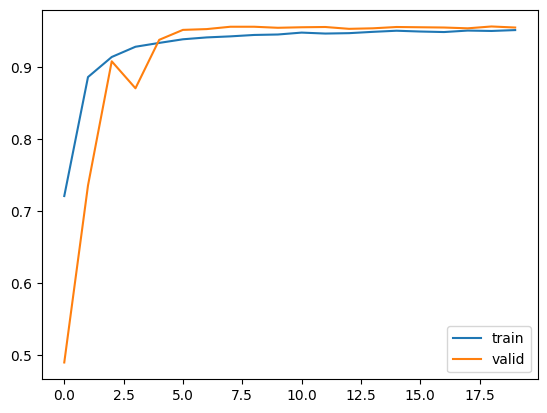

In [32]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'],label='train')
plt.plot(model.history.history['val_accuracy'],label='val')
plt.legend(['train','valid'])